In [1]:
%load_ext autoreload
%autoreload 2

# TUNED | GAUSSIAN PROCESS | ALL VARIABLES

In [2]:
import sys
sys.path.append('../../')
import tokamakTK

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support

pd.set_option('display.max_columns', None)
path = "../../data/"

In [3]:
# Obtained from Optimization

min_subset_ids = pd.read_csv(path+"R_ids_alpha_0.6357.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 

# Setting ELMy Dataset
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# REMOVING SPHERICAL TOKAMAKS
DB5 = DB5[~DB5.TOK.isin(['MAST', 'NSTX', 'START'])]


# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label",value=[0]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label"] = 1


print(
    f"{ round( (len(min_subset_ids)/len(DB5))*100     ,2)  }% of the data decreased alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids)/len(DB5))*100 ,2)  }% of the data did not decrease alpha_R"
)

24.37% of the data decreased alpha_R
75.63% of the data did not decrease alpha_R


Class distribution can be considered is skewed.

## Treatment to Categorical and Numerical Data

In [4]:
features = ['ZEFFNEO', 'EPS', 'WFICFORM', 'BETASTAR', 'RHOSTAR', 'DWDIA', 'KAREA', 'NEL', 
            'OMEGACYCL', 'ENBI', 'WMHD', 'AMIN', 'TAV', 'WFFORM', 'PICRH', 'PLTH', 'MEFF', 
            'QCYL5', 'NUSTAR', 'PNBI', 'VOL', 'LCOULOMB', 'LHTIME', 'PFLOSS', 'BT', 'BEIMHD', 
            'POHM', 'ZEFF', 'PECRH', 'ELMFREQ', 'PRAD', 'NESOL', 'TORQ', 'TOK', 'WALMAT', 
            'DIVNAME', 'LIMMAT', 'HYBRID', 'EVAP', 'ECHMODE', 'PREMAG', 'DIVMAT', 'PELLET', 
            'ELMTYPE', 'AUXHEAT', 'CONFIG']


"""features = ['RHOSTAR', 'TAV', 'NUSTAR', 'ENBI', 'QCYL5', 'LCOULOMB',
       'BETASTAR', 'OMEGACYCL', 'POHM', 'PNBI', 'PLTH', 'PFLOSS', 'NEL',
       'EPS', 'KAREA', 'VOL', 'BT', 'AMIN', 'MEFF', 'WFFORM', 'NESOL',
       'HYBRID', 'BEIMHD', 'DWDIA']"""


DB5 = tokamakTK.clean_categorical_data(DB5)


# Needed to respectively clean each dtype
num_features = DB5[features].select_dtypes(include=['int', 'float']).columns.tolist()
cat_features = DB5[features].select_dtypes(include=['object']).columns.tolist()


data_num = DB5[num_features+["TOK","DATE"]]
data_cat = DB5[cat_features]

data_num = tokamakTK.clean_numerical_data(data_num)

data_ = pd.concat([data_num,
                  (pd.concat([
                       DB5[["label"]], 
                       tokamakTK.encode_categorical_ohe(data_cat)
                      ], axis=1)
                  )],
                  axis=1)

In [5]:
X = data_.drop("label", axis=1)
y = data_["label"]

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=71, stratify=y)

In [6]:
# Define random forest classifier with preprocessor as a pipeline


gp = GaussianProcessClassifier()


gp.fit(X_train, y_train)
y_pred= gp.predict_proba(X_test)

In [7]:
gp.fit(X_train, y_train)
y_pred= gp.predict_proba(X_test)

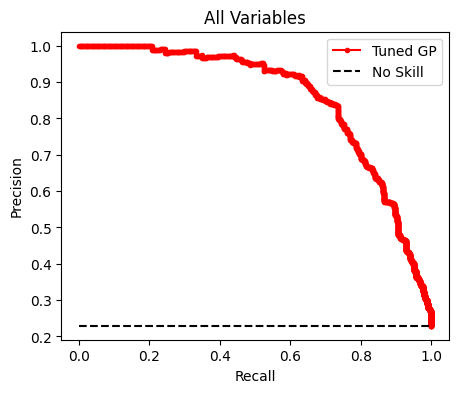

In [8]:
plt.figure(figsize=(5,4))

# keep probabilities for the positive outcome only
y_pred = y_pred[:, 1]
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot(recall, precision, marker='.', label='Tuned GP', color="r")
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill', color="k")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("All Variables")
plt.legend();

In [9]:
y_pred_ = gp.predict(X_test)
precision_recall_fscore_support(y_test, y_pred_, labels=[1,0])

(array([0.83516484, 0.92366412]),
 array([0.73429952, 0.95686556]),
 array([0.781491  , 0.93997175]),
 array([ 414, 1391]))

### FEATURE IMPORTANCE


One way to get the feature importance for a Gaussian Process classifier is to use the **permutation feature importance** method.

For each feature, randomly permute its values in the test data, and compute the recall of the classifier on the permuted data. Repeat this process multiple times to get a more accurate estimate of the feature importance.


In [ ]:
n_permutations = 100
feature_importance = np.zeros(X_train.shape[1])

recall = precision_recall_fscore_support(y_test, y_pred_, labels=[1,0])[1][0]

for i in range(X_train.shape[1]):
    recall_diffs = np.zeros(n_permutations)
    for j in range(n_permutations):
        X_test_permuted = X_test.copy()
        X_test_permuted.iloc[:, i] = np.random.permutation(X_test.iloc[:, i])
        y_pred_permuted = gp.predict(X_test_permuted)
        recall_permuted = precision_recall_fscore_support(y_test, y_pred_permuted, labels=[1,0])[1][0]
        recall_diffs[j] = recall_permuted - recall
    feature_importance[i] = np.mean(recall_diffs)

In [ ]:
sorted_idx = np.argsort(abs(feature_importance))[::-1]
plt.bar(range(X_train.shape[1]), abs(feature_importance[sorted_idx]))
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_idx], rotation=90)
plt.ylabel('Feature importance')
plt.show()